##Data extracting and preprocessing

In [1]:
from PIL import Image
import io
import numpy as np
import pandas as pd

In [2]:
splits = {'train': 'mnist/train-00000-of-00001.parquet', 'test': 'mnist/test-00000-of-00001.parquet'}

In [3]:
##parquet files from hugging face

df_train = pd.read_parquet("hf://datasets/ylecun/mnist/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/ylecun/mnist/" + splits["test"])

In [4]:
n = len(df_train) #10000 samples

##initialize matrix
matrix = np.zeros((784, n))
for i in range(n):
    
    #Read bytes of the raw image
    image_bytes = df_train['image'][i].get('bytes')
    image_object = Image.open(io.BytesIO(image_bytes))
    pixel_values = np.array(image_object.getdata())
    matrix[:, i] = pixel_values / 255.

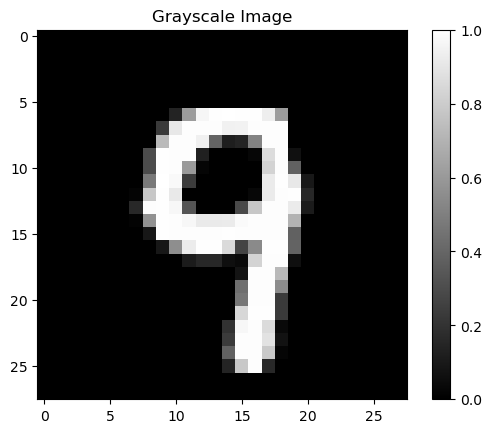

In [5]:
import matplotlib.pyplot as plt

###For visualization of pixels and image
image_pixels = matrix[:, 520]

image_reshaped = image_pixels.reshape(28, 28)

plt.imshow(image_reshaped, cmap='gray', interpolation='nearest')
plt.title(f'Grayscale Image')
plt.colorbar()
plt.show()

In [6]:
x_train = matrix
y_train = np.array(df_train['label'].head(n))

In [7]:
print(x_train[:, 1].shape, y_train.shape)

(784,) (60000,)


In [8]:
##input layer all pixel values 784 x 1:
## 1st hidden layer 10 x 1
## 2nd ouput layer 10 X 1 (values 0-9 (since 10 labels))

##Single neuron: N1 = Wi*X + bi   (Wi is the weights, X is the input, bi is the bias)

## Wi = (10 * 784) X = (784, 1) => (10 x 1) array and bias => (10 x 1), so N1 => (10 x 1)

## W2 = (10 * 10) X = (10 * 1) => (10 x 1) array and bias => (10 x 1), so N2 => (10 x 1)

In [9]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.51
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.52
    b2 = np.random.rand(10, 1) - 0.5
    
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    return np.exp(Z) / sum(np.exp(Z))

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    
    return Z1, A1, Z2, A2

def deriv_ReLU(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def back_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    ## Cost function/Error here is a simple L1 error which we are trying to optimize
    m = Y.size
    one_hot_Y  = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1/ m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)
    
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1/ m * np.sum(dZ1)
    
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    
    return W1, b1, W2, b2


In [10]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    #print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, iterations, alpha):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2  = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 50 == 0:
            print('Iteration: ', i)
            predictions = get_predictions(A2)
            print('Accuracy: ', get_accuracy(predictions, Y))
            
    return W1, b1, W2, b2
        

In [11]:
W1, b1, W2, b2 = gradient_descent(x_train, y_train, 1000, 0.12)

Iteration:  0
Accuracy:  0.10536666666666666
Iteration:  50
Accuracy:  0.46791666666666665
Iteration:  100
Accuracy:  0.6517333333333334
Iteration:  150
Accuracy:  0.7163833333333334
Iteration:  200
Accuracy:  0.7510333333333333
Iteration:  250
Accuracy:  0.7750666666666667
Iteration:  300
Accuracy:  0.79225
Iteration:  350
Accuracy:  0.80685
Iteration:  400
Accuracy:  0.82025
Iteration:  450
Accuracy:  0.8306
Iteration:  500
Accuracy:  0.8387666666666667
Iteration:  550
Accuracy:  0.8457
Iteration:  600
Accuracy:  0.8516666666666667
Iteration:  650
Accuracy:  0.8559833333333333
Iteration:  700
Accuracy:  0.86045
Iteration:  750
Accuracy:  0.8638333333333333
Iteration:  800
Accuracy:  0.8670333333333333
Iteration:  850
Accuracy:  0.8695833333333334
Iteration:  900
Accuracy:  0.87235
Iteration:  950
Accuracy:  0.8741


In [12]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = x_train[:, index, None]
    prediction = make_predictions(x_train[:, index, None], W1, b1, W2, b2)
    label = y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [2]
Label:  2


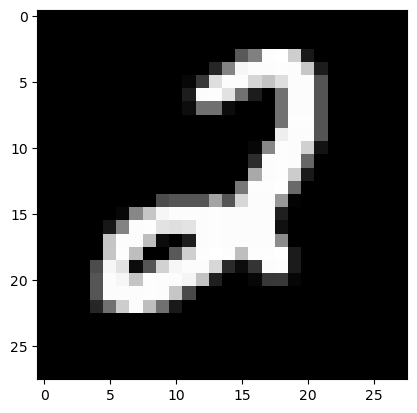

In [13]:
test_prediction(233, W1, b1, W2, b2)

In [14]:
def print_nn_architecture():
    architecture = [
        {"Layer": "Input Layer", "Neurons": 786, "Activation": "-"},
        {"Layer": "Hidden Layer", "Neurons": 10, "Activation": "ReLU"},
        {"Layer": "Output Layer", "Neurons": 10, "Activation": "Softmax"},
    ]
    
    # Print the table header
    print(f"{'Layer':<15} | {'Number of Neurons':<20} | {'Activation Function':<15}")
    print("-" * 60)
    
    # Print each layer's details
    for layer in architecture:
        print(f"{layer['Layer']:<15} | {layer['Neurons']:<20} | {layer['Activation']:<15}")
    
    # Print the architecture overview
    print("\nArchitecture Overview:")
    print("Input Layer (786 neurons)  =>  Hidden Layer (10 neurons, ReLU)  =>  Output Layer (10 neurons, Softmax)")

print_nn_architecture()


Layer           | Number of Neurons    | Activation Function
------------------------------------------------------------
Input Layer     | 786                  | -              
Hidden Layer    | 10                   | ReLU           
Output Layer    | 10                   | Softmax        

Architecture Overview:
Input Layer (786 neurons)  =>  Hidden Layer (10 neurons, ReLU)  =>  Output Layer (10 neurons, Softmax)
